Name: Zhang Haitian 

Student ID: 22M18763

# Preparation 

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import random 
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import wandb 
from tqdm import tqdm 

    Set random seeds

In [58]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False 
    torch.backends.cudnn.deterministic = True 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seeds(6666)

    Split the dataset to train, valid, and test sets, and display it 

In [60]:
def create_path(path):
    """
    create path for splited datasets 
    """
    os.mkdir(path)
    os.mkdir(os.path.join(path, "train"))
    os.mkdir(os.path.join(path, "valid"))
    os.mkdir(os.path.join(path, "test"))

def split_data(c_root, path, c):
    """
    root: root of the dataset classes before splited
    dir: the new directory to store the splited dataset. should have train, valid and test subdirectories
    c: the No. of class in the dataset
    split the data set into train, valid and test sets, rates are 0.6, 0.2, 0.2
    """
    # read files path
    files = []
    for filename in os.listdir(c_root):
        file = os.path.join(c_root, filename)
        files.append(file)
    
    # create train, valid and test folders
    for i in range(len(files)):
        # Naming format: No. of class_original name 
        new_path = str(c) + '_' + files[i].split('/')[-1].split('.')[0] + '.' + files[i].split('.')[-1]
        if i < 0.6*len(files):
            shutil.copyfile(files[i], os.path.join(os.path.join(path, 'train'), new_path))
        elif i < 0.8*len(files):
            shutil.copyfile(files[i], os.path.join(os.path.join(path, 'valid'), new_path))
        else:
            shutil.copyfile(files[i], os.path.join(os.path.join(path, 'test'), new_path))
            
        


In [61]:
root = 'archive'
path = 'data'
c = 0
classes = []
if not os.path.exists(path):
    create_path(path)
    for c_root in os.listdir(root):
        # print(c)  
        classes.append(c_root)
        split_data(os.path.join(root, c_root), path, c)
        print(c, ': ', c_root, 'done')
        c += 1
        

0 :  Hand done
1 :  CXR done
2 :  AbdomenCT done
3 :  ChestCT done
4 :  BreastMRI done
5 :  HeadCT done


# Dataset & Preprocessing 

    Just do a H_filp since the dataset is simple 

In [62]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [63]:
class MedicalDataset(Dataset):
    def __init__(self, path, transform=test_transforms, files=None):
        # super避免多重继承问题
        super(MedicalDataset).__init__()
        self.path = path
        
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path)])
        if files != None:
            self.files = files
        print(self.files[0])
        self.transform = transform
        
    def __getitem__(self, index):
        file = self.files[index]
        img = Image.open(file)
        img = self.transform(img)
        try:
            label = int(file.split('/')[-1].split('_')[0])
        except:
            label = -1 
        
        return img, label 
    
    def __len__(self):
        return len(self.files)

    take a look at the data

data/train/0_000000.jpeg


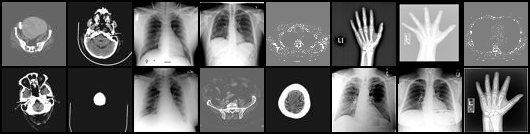

In [64]:
path = 'data'

data_set = MedicalDataset(path=os.path.join(path,'train'), transform=test_transforms)
data_loader = DataLoader(data_set, batch_size=16, shuffle=True)
dataiter = iter(data_loader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
transforms.ToPILImage()(img)

# Model

    Use a Resnet to solve the classification problem

In [76]:
class ResidualBlock(nn.Module):
    """
    Residual Block, which has a residual connection with the input
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.right = None 
        if stride != 1 or in_channels != out_channels:
            self.right = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

In [97]:
class Resnet(nn.Module):
    def __init__(self, layers=[2, 3], num_classes=6):
        """
        The ResNet model, the defualt is ResNet18
        """
        super(Resnet, self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(1, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1 = self.make_layer(64, 64, layers[0])
        self.layer2 = self.make_layer(64, 128, layers[1], stride=2)
        
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for i in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
            
    def forward(self, x):
        out = self.pre(x)
        out = self.layer1(out)
        out = self.layer2(out)

        out = F.avg_pool2d(out, 4)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out 

# Training

In [99]:
# can choose to use wandb to display the data
use_wandb = False 
if use_wandb:
    !pip install wandb 
    !wandb login

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-4 
model = Resnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
epochs = 10
batch_size = 64
ex_name = 'resnet_adam'
log_path = 'log'
if not os.path.exists(log_path):
    os.mkdir(log_path)
# load data 
if device == 'cuda':
    train_data = MedicalDataset(path=os.path.join(path,'train'), transform=train_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)

    valid_data = MedicalDataset(path=os.path.join(path,'valid'), transform=test_transforms)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=8)

else:
    train_data = MedicalDataset(path=os.path.join(path,'train'), transform=train_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    valid_data = MedicalDataset(path=os.path.join(path,'valid'), transform=test_transforms)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)


data/train/0_000000.jpeg
data/valid/0_000001.jpeg


In [101]:
def train(model, train_loader, valid_loader, criterion, optimizer, epoch=10, use_wandb=False):
    if use_wandb:
        wandb.init(project='Medical MNIST')
        config = wandb.config 
        config.lr = lr 
        config.batch_size = batch_size
        config.epochs = epochs

    best_acc = 0.0
    for epoch in range(epochs):
        example_images = []
        # model.train()
        train_acc = 0
        train_loss = 0
        for imgs, labels in tqdm(train_loader):
            out = model(imgs.to(device))
            predict = out.argmax(dim=1)
            loss = criterion(out, labels.to(device))
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            acc = (predict == labels.to(device)).float().mean()   
            train_acc += acc
            train_loss += loss.item()

        # train loss and acc of every epoch 
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_acc / len(train_loader)

        print(f'| Train | {epoch + 1:03d}/{epochs:03d} | loss = {epoch_train_loss:.5f}, train acc= {epoch_train_acc:.5f}')

        model.eval()
        valid_loss = 0 
        valid_acc = 0 

        for imgs, labels in tqdm(valid_loader):
            out = model(imgs.to(device))
            predict = out.argmax(dim=1)
            loss = criterion(out, labels.to(device))
            acc = (predict == labels.to(device)).float().mean()
        
            valid_loss += loss.item()
            valid_acc += acc 

        # valid loss and acc of every epoch
        epoch_valid_loss = valid_loss / len(valid_loader)
        epoch_valid_acc = valid_acc / len(valid_loader)

        print(f'| Valid | {epoch + 1:03d}/{epochs:03d} | loss = {epoch_valid_loss:.5f}, valid acc= {epoch_valid_acc:.5f}')

        if use_wandb:
            wandb.log({
                'train_loss': epoch_train_loss,
                'train_acc': epoch_train_acc,
                'valid_loss': epoch_valid_loss,
                'valid_acc': epoch_valid_acc
            })

        if epoch_valid_acc > best_acc:
            print(f"[ Valid | {epoch + 1:03d}/{epochs:03d} ] loss = {epoch_valid_loss:.5f}, valid acc = {epoch_valid_acc:.5f} -> best")
            print(f'Best model found at epoch {epoch}, saving!')
            best_acc = epoch_valid_acc
            torch.save(model.state_dict(), os.path.join(log_path, ex_name + '.pth'))
            stale = 0
        else:
            stale += 1
            if stale == 10:
                print(f'Early stop at epoch {epoch}')
                break


In [102]:
train(model, train_loader, valid_loader, criterion, optimizer, epochs, use_wandb)

100%|██████████| 553/553 [00:11<00:00, 46.72it/s]


| Train | 001/010 | loss = 0.03156, train acc= 0.99319


100%|██████████| 185/185 [00:01<00:00, 124.12it/s]


| Valid | 001/010 | loss = 0.00363, valid acc= 0.99924
[ Valid | 001/010 ] loss = 0.00363, valid acc = 0.99924 -> best
Best model found at epoch 0, saving!


100%|██████████| 553/553 [00:12<00:00, 45.67it/s]


| Train | 002/010 | loss = 0.01389, train acc= 0.99630


100%|██████████| 185/185 [00:01<00:00, 110.62it/s]


| Valid | 002/010 | loss = 0.00312, valid acc= 0.99932
[ Valid | 002/010 ] loss = 0.00312, valid acc = 0.99932 -> best
Best model found at epoch 1, saving!


100%|██████████| 553/553 [00:12<00:00, 44.68it/s]


| Train | 003/010 | loss = 0.00245, train acc= 0.99921


100%|██████████| 185/185 [00:01<00:00, 112.74it/s]


| Valid | 003/010 | loss = 0.00464, valid acc= 0.99890


100%|██████████| 553/553 [00:13<00:00, 41.57it/s]


| Train | 004/010 | loss = 0.00173, train acc= 0.99946


100%|██████████| 185/185 [00:01<00:00, 101.80it/s]


| Valid | 004/010 | loss = 0.00828, valid acc= 0.99823


100%|██████████| 553/553 [00:13<00:00, 39.57it/s]


| Train | 005/010 | loss = 0.00498, train acc= 0.99881


100%|██████████| 185/185 [00:01<00:00, 106.43it/s]


| Valid | 005/010 | loss = 0.00208, valid acc= 0.99941
[ Valid | 005/010 ] loss = 0.00208, valid acc = 0.99941 -> best
Best model found at epoch 4, saving!


100%|██████████| 553/553 [00:13<00:00, 39.84it/s]


| Train | 006/010 | loss = 0.00134, train acc= 0.99963


100%|██████████| 185/185 [00:02<00:00, 88.27it/s] 


| Valid | 006/010 | loss = 0.00332, valid acc= 0.99941


100%|██████████| 553/553 [00:13<00:00, 40.27it/s]


| Train | 007/010 | loss = 0.00239, train acc= 0.99912


100%|██████████| 185/185 [00:01<00:00, 96.62it/s] 


| Valid | 007/010 | loss = 0.00245, valid acc= 0.99941


100%|██████████| 553/553 [00:14<00:00, 38.56it/s]


| Train | 008/010 | loss = 0.00727, train acc= 0.99794


100%|██████████| 185/185 [00:02<00:00, 87.50it/s] 


| Valid | 008/010 | loss = 0.00284, valid acc= 0.99941


100%|██████████| 553/553 [00:13<00:00, 40.37it/s]


| Train | 009/010 | loss = 0.00373, train acc= 0.99910


100%|██████████| 185/185 [00:01<00:00, 98.39it/s] 


| Valid | 009/010 | loss = 0.00940, valid acc= 0.99721


100%|██████████| 553/553 [00:13<00:00, 41.04it/s]


| Train | 010/010 | loss = 0.00138, train acc= 0.99949


100%|██████████| 185/185 [00:01<00:00, 99.53it/s] 

| Valid | 010/010 | loss = 0.00331, valid acc= 0.99932


data/test/0_000007.jpeg
true label: 3 0 3 3 0 1 0 4 2 0 2 5 0 2 0 5


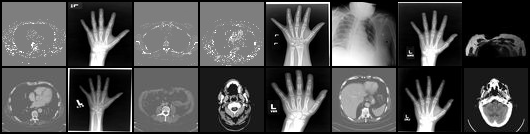

In [107]:
test_data = MedicalDataset(path=os.path.join(path,'test'), transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=16)

testiter = iter(test_loader)
images, labels = testiter.next()
str(int(labels[1]))

# print true labels and images
print('true label:', ' '.join(str(int(labels[j])) for j in range(16)))
img = torchvision.utils.make_grid(images)
transforms.ToPILImage()(img)

In [108]:
# print predicted 
output = model(images.to('cuda'))
_, predict = torch.max(output, axis=1)
p2 = output.argmax(axis=1)
_, predict,p2


(tensor([10.7770, 21.2892, 12.0213, 10.3525, 15.5570, 18.2579, 19.0626, 13.0021,
         14.6633, 16.2579, 15.8741, 16.9960, 16.1408,  9.3410, 15.0619, 20.8909],
        device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([3, 0, 3, 3, 0, 1, 0, 4, 2, 0, 2, 5, 0, 2, 0, 5], device='cuda:0'),
 tensor([3, 0, 3, 3, 0, 1, 0, 4, 2, 0, 2, 5, 0, 2, 0, 5], device='cuda:0'))

In [105]:
def test(model, test_loader, criterion):
    model.eval()
    test_acc = 0
    test_loss = 0
    for imgs, labels in tqdm(test_loader):
        out = model(imgs.to(device))
        predict = out.argmax(dim=1)
        loss = criterion(out, labels.to(device))
        acc = (predict == labels.to(device)).float().mean()
        
        test_loss += loss.item()
        test_acc += acc 

    # test loss and acc of every epoch
    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = test_acc / len(test_loader)

    print(f'| Test | loss = {epoch_test_loss:.5f}, test acc= {epoch_test_acc:.5f}')

In [106]:
test(model, test_loader, criterion)

100%|██████████| 737/737 [00:06<00:00, 116.46it/s]

| Test | loss = 0.00077, test acc= 0.99975
